In this tutorial, we're going to build and train such a deeplearning based model using tensorflow recommenders to recommend Amazon Product for a specific user oriented behaviour. Lets suppose we have a person A who wants to order beer from amazon. He will simple goto the link https://www.amazon.com/b?ie=UTF8&node=2983385011 and purchase the beer. But we want to build a customized deeplearning based model which will that user the recommendations which he wants. 

For this purpose we are going to use tensorflow recommenders. So in this tutorial 

we're going to:

1. Get our data and split it into a training and test set.

2. Implement a retrieval model.

3. Fit and evaluate it.

4. Get recommendations for that person A based on his choices / experience.


# Install Tensorflow Recommenders

In [ ]:
!pip install tensorflow-recommenders


**Optional**

In [ ]:
!pip install scann

# Import Libararis

In [121]:
import os
import pprint
import tempfile
import pandas as pd
from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

# Load Dataset

In [122]:
# Ratings data.
df = pd.read_csv('amazon_product_beer.csv')
df

,brewery_id,score,username,text,style,abv,brewery_name,beer_name
0,10325,1.5,stcules,My Favorite White Wine,Hefeweizen,5.0,Vecchio Birraio,Sausa Weizen
1,10325,3.0,stcules,Yum!!,English Strong Ale,6.2,Vecchio Birraio,Red Moon
2,10325,3.0,stcules,A New Favorite!,Foreign / Export Stout,6.5,Vecchio Birraio,Black Horse Black Beer
3,10325,3.0,stcules,"Bold, Flavorful, Aromatic, Delicious",German Pilsener,5.0,Vecchio Birraio,Sausa Pils
4,1075,4.0,johnmichaelsen,"Yum! Plus, Environmentally Friendly!",American Double / Imperial IPA,7.7,Caldera Brewing Company,Cauldron DIPA
...,...,...,...,...,...,...,...,...
2841,14879,4.0,goblue3509,Excellent,American Double / Imperial IPA,10.0,Hoppin' Frog Brewery,Hop Dam Triple IPA
2842,14879,4.0,heysuz,Delicious !!,American Double / Imperial IPA,10.0,Hoppin' Frog Brewery,Hop Dam Triple IPA
2843,14879,4.0,BeerWanker,Sumptuous delicious wine.,American Double / Imperial IPA,10.0,Hoppin' Frog Brewery,Hop Dam Triple IPA
2844,14879,1.5,PittBeerGirl,Excellent Moscato,American Double / Imperial IPA,10.0,Hoppin' Frog Brewery,Hop Dam Triple IPA


# Data Visualization 

(-0.5, 1599.5, 799.5, -0.5)

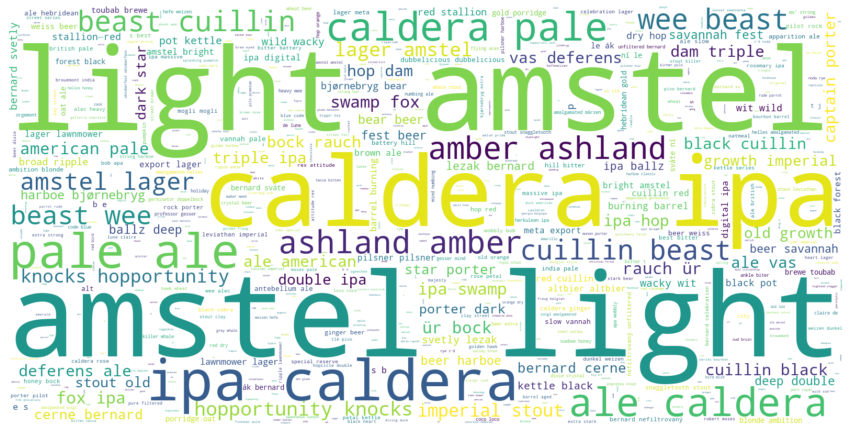

In [123]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
word_string1=" ".join(df['beer_name'].str.lower())
plt.figure(figsize=(15,15))
wc = WordCloud(background_color="white", stopwords = STOPWORDS, max_words=2000, max_font_size= 300,  width=1600, height=800)
wc.generate(word_string1)

plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Consider that person "A" has the user name "stucles" in Amazon products dataset, so lets see what are his choices / experiences before

In [124]:
# append your reviews to the dataframe to get your own predictions
print("User A reviews: ")
df[df['username']=='stcules'].head()

User A reviews: 


,brewery_id,score,username,text,style,abv,brewery_name,beer_name
0,10325,1.5,stcules,My Favorite White Wine,Hefeweizen,5.0,Vecchio Birraio,Sausa Weizen
1,10325,3.0,stcules,Yum!!,English Strong Ale,6.2,Vecchio Birraio,Red Moon
2,10325,3.0,stcules,A New Favorite!,Foreign / Export Stout,6.5,Vecchio Birraio,Black Horse Black Beer
3,10325,3.0,stcules,"Bold, Flavorful, Aromatic, Delicious",German Pilsener,5.0,Vecchio Birraio,Sausa Pils
1508,16604,4.0,stcules,Perfect for thieving beer from unsuspecting fe...,Munich Dunkel Lager,NaN,Landhausbräu Koller,Kollers Naturtrüb Dunkel


# Some Data Preparations to obtain Unique Name

In [125]:
# create dicts of unique beers and users for embeddings

df_beer = df['beer_name'].unique()
df_beer = pd.DataFrame(df_beer, columns = ['beer_name'])

df_ratings = df[['username', 'beer_name']]
df_ratings = df_ratings.dropna()

# convert dataframes to tensors
tf_beer_dict = tf.data.Dataset.from_tensor_slices(dict(df_beer))
tf_ratings_dict = tf.data.Dataset.from_tensor_slices(dict(df_ratings))

In [126]:
df_ratings

,username,beer_name
0,stcules,Sausa Weizen
1,stcules,Red Moon
2,stcules,Black Horse Black Beer
3,stcules,Sausa Pils
4,johnmichaelsen,Cauldron DIPA
...,...,...
2841,goblue3509,Hop Dam Triple IPA
2842,heysuz,Hop Dam Triple IPA
2843,BeerWanker,Hop Dam Triple IPA
2844,PittBeerGirl,Hop Dam Triple IPA


# Rating our data

In [127]:
# map rows to a dictionary
ratings = tf_ratings_dict.map(lambda x: {
    "beer_name": x["beer_name"],
    "username": x["username"]
})

beer_list = tf_beer_dict.map(lambda x: x['beer_name'])

In [128]:
# we'll use these later for the embeddings
usernames = ratings.map(lambda x: x['username'])
unique_users = np.unique(np.concatenate(list(usernames.batch(1000))))
unique_beers = np.unique(np.concatenate(list(beer_list.batch(1000))))

To fit and evaluate the model, we need to split it into a training and evaluation set. In an industrial recommender system, this would most likely be done by time: the data up to time  T  would be used to predict interactions after  T .

In this simple example, however, let's use a random split, putting 80% of the ratings in the train set, and 20% in the test set.

In [129]:
# shuffle + test/train split
tf.random.set_seed(42)
shuffled = ratings.shuffle(len(df), seed=42, reshuffle_each_iteration=False)
                          
train = shuffled.take(int(len(df)*0.8))
test = shuffled.skip(int(len(df)*0.8)).take(int(len(df)*0.2))

# Model Development

In [130]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [131]:
# extend the tfrs class
class AmazonProduct(tfrs.Model):
    def __init__(self):
        super().__init__()
        
    # The first step is to decide on the dimensionality of the query and candidate representations:
    
        embedding_dims = 32
        
# Higher values will correspond to models that may be more accurate, but will also be slower to 
#fit and more prone to overfitting.

# The query Tower

#The second is to define the model itself. Here, we're going to use Keras 
#preprocessing layers to first convert user ids to integers, and then convert those 
#to user embeddings via an Embedding layer. Note that we use the list of 
#unique user ids we computed earlier as a vocabulary:

        self.user_model =  tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary= unique_users, mask_token=None),
            tf.keras.layers.Embedding(len(unique_users)+1, embedding_dims)
        ])
    
    
# The candidate Tower 

        self.beer_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_beers, mask_token=None),
            tf.keras.layers.Embedding(len(unique_beers)+1, embedding_dims)
        ])
#In our training data we have positive (user, beer_name) pairs. To figure out how good our model is, 
#we need to compare the affinity score that the model calculates for this pair to the scores of 
#all the other possible candidates: if the score for the positive pair is higher than for all 
#other candidates, our model is highly accurate.

#To do this, we can use the tfrs.metrics.FactorizedTopK metric. The metric has one required 
#argument: the dataset of candidates that are used as implicit negatives for evaluation.

#In our case, that's the beers dataset, converted into embeddings via our beer model:
        self.task = tfrs.tasks.Retrieval(
                        metrics=tfrs.metrics.FactorizedTopK(
                        candidates=beer_list.batch(128).cache().map(self.beer_model)
                        ))
#The next component is the loss used to train our model. TFRS has several loss layers and tasks to make this easy.

#In this instance, we'll make use of the Retrieval task object: a convenience wrapper that bundles together 
#the loss function and metric computation:       
    
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        user_embeddings = self.user_model(features['username'])
        beer_embeddings = self.beer_model(features['beer_name'])
        return self.task(user_embeddings, beer_embeddings)
        

# Define the Keras TensorBoard callback.

In [132]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Fitting and evaluating

After defining the model, we can use standard Keras fitting and evaluation routines to fit and evaluate the model.

Let's first instantiate the model.

In [133]:
# initiate Model
model = AmazonProduct()
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

Then shuffle, batch, and cache the training and evaluation dat

In [134]:
# Train Model

freq = 2
epochs = 20

history = model.fit(
    
                train.batch(8192),
                validation_data= test.batch(512),
                validation_freq=freq,
                epochs = epochs,
                verbose = 0,
                callbacks=[tensorboard_callback])

# Validation

In [135]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 10724), started 1:25:56 ago. (Use '!kill 10724' to kill it.)

In [136]:
model.evaluate(test.batch(8192), return_dict=True)

1/1 [==============================] - 0s 103ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0018 - factorized_top_k/top_5_categorical_accuracy: 0.0334 - factorized_top_k/top_10_categorical_accuracy: 0.0791 - factorized_top_k/top_50_categorical_accuracy: 0.3128 - factorized_top_k/top_100_categorical_accuracy: 0.4429 - loss: 4714.4888 - regularization_loss: 0.0000e+00 - total_loss: 4714.4888


{'factorized_top_k/top_1_categorical_accuracy': 0.0017574692610651255,
 'factorized_top_k/top_5_categorical_accuracy': 0.03339191526174545,
 'factorized_top_k/top_10_categorical_accuracy': 0.07908611744642258,
 'factorized_top_k/top_50_categorical_accuracy': 0.31282952427864075,
 'factorized_top_k/top_100_categorical_accuracy': 0.442882239818573,
 'loss': 4714.48876953125,
 'regularization_loss': 0,
 'total_loss': 4714.48876953125}

# Optional

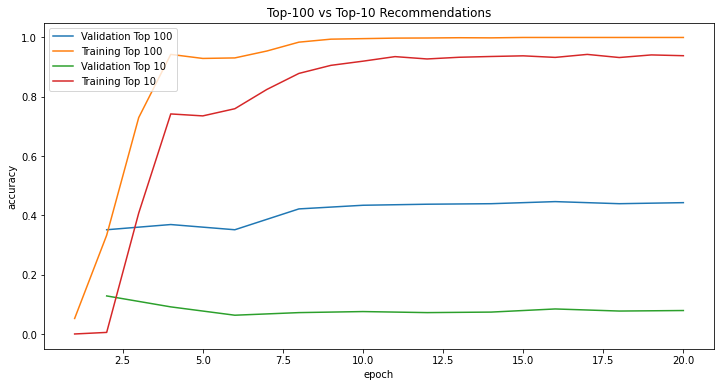

In [137]:
#notice how back the accuracy is when only prediction the top 10 since no scores are input
plt.figure(figsize=(12,6))
num_validation_runs = len(history.history["val_factorized_top_k/top_10_categorical_accuracy"])
epochs = [(x + 1)* freq for x in range(num_validation_runs)]

plt.plot(epochs, history.history["val_factorized_top_k/top_100_categorical_accuracy"], label = "Validation Top 100")
plt.plot(np.linspace(1, len( history.history["factorized_top_k/top_100_categorical_accuracy"]), 
                     len( history.history["factorized_top_k/top_100_categorical_accuracy"])),
                     history.history["factorized_top_k/top_100_categorical_accuracy"], label = "Training Top 100")
plt.plot(epochs, history.history["val_factorized_top_k/top_10_categorical_accuracy"], label = "Validation Top 10")
plt.plot(np.linspace(1, len( history.history["factorized_top_k/top_10_categorical_accuracy"]), 
                     len( history.history["factorized_top_k/top_10_categorical_accuracy"])),
                     history.history["factorized_top_k/top_10_categorical_accuracy"], label = "Training Top 10")
plt.title("Top-100 vs Top-10 Recommendations")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

# Test Recommender Model

In [138]:
# Save Model

# ScaNN can be used in production instead of brute force to speed up prediction times
# Since this is a small dataset  I'll just use brute force
# "k" dictates the number of recommendations to be pulled in production
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(beer_list.batch(128).map(lambda beer_name: (beer_name, model.beer_model(beer_name))))

    


# Make Predictions for the beer for our user A

In [139]:
# Need to call it to set the shapes.The string could be anything
_,titles= index(tf.constant(["stcules"]))

print(f"Recommendations for user stcules: {titles[0, :10]}")

Recommendations for user stcules: [b'Red Moon' b'Kollers Naturtr\xc3\xbcb Hell' b'Sausa Pils'
 b'Sausa Weizen' b'Kollers Naturtr\xc3\xbcb Dunkel'
 b'Bernard Nefiltrovan\xc3\xbd (unfiltered)' b'Black Cuillin'
 b'Brew Eyed Blond' b'Polymer Pilsner' b"Ankle Biter Ale '07"]
